# Imports

In [1]:
# os & files
import os, io, shutil
import urllib, requests
from urllib.request import urlopen
from io import BytesIO
from zipfile import ZipFile
from google.colab import files

import math, random
from collections import Counter

import numpy as np
import pandas as pd
import networkx as nx

import PIL
import wordcloud
from wordcloud import WordCloud

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import json
from xml.etree.ElementTree import parse
from xml.dom import minidom

import re

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

!pip install profanity-check
from profanity_check import predict, predict_prob

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
     |████████████████████████████████| 2.4MB 2.8MB/s 


/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.20.2 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator LinearSVC from version 0.20.2 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklea

# Tools

In [0]:
# Reformats filenames to match the links
def from_name_to_filename(name):
    filename = name.split(" (")[0]
    filename = filename.replace("\\","%")
    filename = filename.replace(":","-")
    if("9" in name):
        name.replace("9","#9")
    return filename + '.json'

In [0]:
# Reformats filenames to match the links
def from_file_to_name(filename):
    name = filename.split(".json")[0]
    name = name.replace("%","\\")
    name = name.replace(":","-")
    return name

In [0]:
# Reformats info to be consistent
def reformat(str):
    str = str.split("}")[0]
    str = str.split("<")[0]
    str = str.replace("\\\\n","")
    str = str.replace("[[","")
    str = str.replace("]]","")
    str = str.replace("\\\\\\","")
    return str

In [0]:
# zipurl = 'https://github.com/RmnRss/R-M-Social-Graph/raw/master/Characters.zip?raw=true'
# with urlopen(zipurl) as zipresp:
#     with ZipFile(BytesIO(zipresp.read())) as zfile:
#         zfile.extractall(path='.')

## Cleaning files

In [0]:
# folder = os.getcwd() + '/Episodes/Season 3/'

# for the_file in os.listdir(folder):
#   file_path = os.path.join(folder, the_file)
#   try:
#     if os.path.isfile(file_path):
#       os.unlink(file_path)
#     elif os.path.isdir(file_path):
#         shutil.rmtree(file_path)
#   except Exception as e:
#        print('Failed to delete %s. Reason: %s' % (file_path, e))

## Downloading to local drive

In [0]:
# !zip -r /content/characters.zip /content/Characters
# files.download('/content/characters.zip')

# Project Structure

In [0]:
# Create relevant folders
paths = ['Characters', 'Episodes', 'Transcripts', 'Songs','Images','Graphs','Plots']
for path in paths:
  if not os.path.exists('./' + path):
      os.makedirs('./' + path)

In [0]:
# Creating folders for Episodes
paths = ['Season 1', 'Season 2', 'Season 3']
for path in paths:
  if not os.path.exists('./Episodes/' + path):
      os.makedirs('./Episodes/' + path)

In [0]:
# Creating folders for Transcripts
paths = ['Season 1', 'Season 2', 'Season 3']
for path in paths:
  if not os.path.exists('./Transcripts/' + path):
      os.makedirs('./Transcripts/' + path)

# Downloading data

## Characters

<em>Dataset downloaded from: https://rickandmorty.fandom.com</em>

In [11]:
baseurl = "https://rickandmorty.fandom.com/api.php?"
action = "action=query"
theList = "list=categorymembers"
cmtitle = "cmtitle=Category:Characters"
cmlimit = "cmlimit=500"
content = "prop=revisions&rvprop=content"
dataformat = "format=json"

query = "%s%s&%s&%s&%s&%s&%s" % (baseurl, action, theList, cmtitle, cmlimit, content, dataformat)
print(query)

https://rickandmorty.fandom.com/api.php?action=query&list=categorymembers&cmtitle=Category:Characters&cmlimit=500&prop=revisions&rvprop=content&format=json


In [12]:
# Save first 500 wikipagenames

response = urllib.request.urlopen(query)
source = response.read()

jsonObj = json.loads(source)
# Extract continue param for getting rest of names
continueParam = jsonObj['query-continue']['categorymembers']['cmcontinue']

print(query + '&cmcontinue=' + continueParam)
response2 = urllib.request.urlopen(query + '&cmcontinue=' + continueParam)
source2 = response2.read()
jsonObj2 = json.loads(source2)

wikiPageName = []
for i in jsonObj['query']['categorymembers']:
    wikiPageName.append(i['title'])

for i in jsonObj2['query']['categorymembers']:
    wikiPageName.append(i['title'])

https://rickandmorty.fandom.com/api.php?action=query&list=categorymembers&cmtitle=Category:Characters&cmlimit=500&prop=revisions&rvprop=content&format=json&cmcontinue=page|5445444459205249434b|25105


In [0]:
# API fetching
apiUrl = urllib.parse.quote('https://rickandmortyapi.com/api/character/' + str(list(range(1, 550))).replace(' ', ''), safe=':/') 
response = urllib.request.urlopen(apiUrl)
source = response.read()
jsonObj = json.loads(source)
apiNames, c_tuples = [], []
for result in jsonObj:
  apiNames.append(result['name'])
  c_tuple = (result['name'], result['species'], result['status'], result['image'], result['location'])
  c_tuples.append(c_tuple)

### Dataframe Creation

In [14]:
characters_parsed = [urllib.parse.quote(x.lower()) for x in wikiPageName]
validCharacterNames = []
# Keep only characters that exist both in API and on Wiki, to avoid including characters in comic issues
for name in apiNames:
  name_parsed = urllib.parse.quote(name.lower())
  if name_parsed in characters_parsed:
    if name not in validCharacterNames:
      validCharacterNames.append(name)

valid_tuples = []
for c_tuple in c_tuples:
  if c_tuple[0] in validCharacterNames:
    if c_tuple[0] not in [x[0] for x in valid_tuples]:
      valid_tuples.append(c_tuple)

# Creating DataFrame
df = pd.DataFrame(valid_tuples, columns = ['Name','Specie','Status', 'ImageUrl', 'LastKnownLocation'])
df.head(10)

,Name,Specie,Status,ImageUrl,LastKnownLocation
0,Rick Sanchez,Human,Alive,https://rickandmortyapi.com/api/character/avat...,"{'name': 'Earth (Replacement Dimension)', 'url..."
1,Morty Smith,Human,Alive,https://rickandmortyapi.com/api/character/avat...,"{'name': 'Earth (Replacement Dimension)', 'url..."
2,Summer Smith,Human,Alive,https://rickandmortyapi.com/api/character/avat...,"{'name': 'Earth (Replacement Dimension)', 'url..."
3,Beth Smith,Human,Alive,https://rickandmortyapi.com/api/character/avat...,"{'name': 'Earth (Replacement Dimension)', 'url..."
4,Jerry Smith,Human,Alive,https://rickandmortyapi.com/api/character/avat...,"{'name': 'Earth (Replacement Dimension)', 'url..."
5,Abadango Cluster Princess,Alien,Alive,https://rickandmortyapi.com/api/character/avat...,"{'name': 'Abadango', 'url': 'https://rickandmo..."
6,Abradolf Lincler,Human,unknown,https://rickandmortyapi.com/api/character/avat...,"{'name': 'Testicle Monster Dimension', 'url': ..."
7,Adjudicator Rick,Human,Dead,https://rickandmortyapi.com/api/character/avat...,"{'name': 'Citadel of Ricks', 'url': 'https://r..."
8,Agency Director,Human,Dead,https://rickandmortyapi.com/api/character/avat...,"{'name': 'Earth (Replacement Dimension)', 'url..."
9,Alan Rails,Human,Dead,https://rickandmortyapi.com/api/character/avat...,"{'name': 'Worldender's lair', 'url': 'https://..."


In [15]:
baseurl = "https://rickandmorty.fandom.com/api.php?"
action = "action=query"
revision = "prop=revisions"
content = "rvprop=content"
dataformat = "format=json"
limit = "rvlimit=1"

for name in validCharacterNames:
    print(name)
    
    # Parsing name for url
    urlName = urllib.parse.quote(name, safe='')
        
    # Building the query
    title = "titles=" + urlName
    query = "%s%s&%s&%s&%s&%s&%s" % (baseurl, action, revision, title, content, dataformat, limit)
    
    # Calling API
    response = urllib.request.urlopen(query)
    source = response.read()

    # Loading Json
    jsonObj = json.loads(source)
    
    # Getting page ID
    pageid = list(jsonObj['query']['pages'].keys())[0]
    
    # Getting content
    if name != 'Agency Director': # TODO: REMOVE THIS CHECK WHEN API IS UPDATED
      fileContent = jsonObj['query']['pages'][pageid]['revisions'][0]['*']
    
    # Converting to a utf-8 string
    utfContent = (str(fileContent).encode())

    # Writing in files
    path = './Characters/' + name
    file = open(path + ".json", "wb")    
    file.write(utfContent) 
    file.close()

Rick Sanchez
Morty Smith
Summer Smith
Beth Smith
Jerry Smith
Abadango Cluster Princess
Abradolf Lincler
Adjudicator Rick
Agency Director
Alan Rails
Albert Einstein
Alexander
Alien Googah
Alien Morty
Alien Rick
Amish Cyborg
Annie
Antenna Morty
Antenna Rick
Ants in my Eyes Johnson
Aqua Morty
Aqua Rick
Arcade Alien
Armagheadon
Armothy
Arthricia
Artist Morty
Attila Starwar
Baby Legs
Baby Poopybutthole
Baby Wizard
Bearded Lady
Beebo
Benjamin
Beta-Seven
Beth's Mytholog
Big Boobed Waitress
Big Morty
Bill
Birdperson
Blim Blam
Blue Footprint Guy
Blue Shirt Morty
Bobby Moynihan
Bootleg Portal Chemist Rick
Brad
Brad Anderson
Calypso
Campaign Manager Morty
Canklanker Thom
Centaur
Chris
Collector
Colossus
Commander Rick
Concerto
Conroy
Cool Rick
Cop Morty
Cop Rick
Courier Flap
Cousin Nicky
Crab Spider
Crocubot
Cronenberg Rick
Cronenberg Morty
Cult Leader Morty
Cyclops Morty
Cyclops Rick
Cynthia
Dale
Daron Jefferson
David Letterman
Davin
Diablo Verde
Diane Sanchez
Dipper and Mabel Mortys
Donna Guete

In [16]:
# Sanity check 
print(len(validCharacterNames))
print(len([name for name in os.listdir('./Characters')]))
print(len(df))

313
313
313


### Images

In [0]:
#for i in range(0, len(df)):
#  path = './Images/' + df.iloc[i].Name + '.jpg'
#  url = df.iloc[i].ImageUrl
#  f = open(path,'wb')
#  f.write(urllib.request.urlopen(url).read())
#  f.close()

## Episodes

In [18]:
# API fetching
apiUrl = urllib.parse.quote('https://rickandmortyapi.com/api/episode/' + str(list(range(1, 32))).replace(' ', ''), safe=':/') 
response = urllib.request.urlopen(apiUrl)
source = response.read()
jsonObj = json.loads(source)

apiEpisodesNames, episodes_tuples = [], []

for result in jsonObj:
  apiEpisodesNames.append(result['name'])
  c_tuple = (result['name'], result['episode'], result['air_date'], 0, '')
  episodes_tuples.append(c_tuple)

# Creating DataFrame
df_ep = pd.DataFrame(episodes_tuples, columns = ['Name','Code','Air Date', 'Views', 'Transcript'])
df_ep.head(10)

,Name,Code,Air Date,Views,Transcript
0,Pilot,S01E01,"December 2, 2013",0,
1,Lawnmower Dog,S01E02,"December 9, 2013",0,
2,Anatomy Park,S01E03,"December 16, 2013",0,
3,M. Night Shaym-Aliens!,S01E04,"January 13, 2014",0,
4,Meeseeks and Destroy,S01E05,"January 20, 2014",0,
5,Rick Potion #9,S01E06,"January 27, 2014",0,
6,Raising Gazorpazorp,S01E07,"March 10, 2014",0,
7,Rixty Minutes,S01E08,"March 17, 2014",0,
8,Something Ricked This Way Comes,S01E09,"March 24, 2014",0,
9,Close Rick-counters of the Rick Kind,S01E10,"April 7, 2014",0,


#### Season 1

In [19]:
baseurl = "https://rickandmorty.fandom.com/api.php?"
action = "action=query"
theList = "list=categorymembers"
cmtitle = "cmtitle=Category:Season%201%20episodes"
cmlimit = "cmlimit=500"
content = "prop=revisions&rvprop=content"
dataformat = "format=json"

query = "%s%s&%s&%s&%s&%s&%s" % (baseurl, action, theList, cmtitle, cmlimit, content, dataformat)
print(query)

https://rickandmorty.fandom.com/api.php?action=query&list=categorymembers&cmtitle=Category:Season%201%20episodes&cmlimit=500&prop=revisions&rvprop=content&format=json


In [0]:
response = urllib.request.urlopen(query)
source = response.read()

In [0]:
s1_episodes = []

jsonObj = json.loads(source)
for i in jsonObj['query']['categorymembers']:
    s1_episodes.append(i['title'])

In [0]:
s1_episodes.remove('Season 1')

In [23]:
s1_episodes

['Anatomy Park (episode)',
 'Close Rick-counters of the Rick Kind',
 'Lawnmower Dog',
 'M. Night Shaym-Aliens!',
 'Meeseeks and Destroy',
 'Pilot',
 'Raising Gazorpazorp',
 'Rick Potion 9',
 'Ricksy Business',
 'Rixty Minutes',
 'Something Ricked This Way Comes']

#### Season 2

In [24]:
cmtitle = "cmtitle=Category:Season%202%20episodes"

query = "%s%s&%s&%s&%s&%s&%s" % (baseurl, action, theList, cmtitle, cmlimit, content, dataformat)
print(query)

https://rickandmorty.fandom.com/api.php?action=query&list=categorymembers&cmtitle=Category:Season%202%20episodes&cmlimit=500&prop=revisions&rvprop=content&format=json


In [0]:
response = urllib.request.urlopen(query)
source = response.read()

In [0]:
s2_episodes = []

jsonObj = json.loads(source)
for i in jsonObj['query']['categorymembers']:
    s2_episodes.append(i['title'])

In [0]:
s2_episodes.remove('Season 2')

In [28]:
s2_episodes

['Auto Erotic Assimilation',
 'Big Trouble in Little Sanchez',
 'Get Schwifty',
 'Interdimensional Cable 2: Tempting Fate',
 "Look Who's Purging Now",
 'Mortynight Run',
 'A Rickle in Time',
 'The Ricks Must Be Crazy',
 'Total Rickall',
 'The Wedding Squanchers']

### Season 3

In [29]:
cmtitle = "cmtitle=Category:Season%203%20episodes"

query = "%s%s&%s&%s&%s&%s&%s" % (baseurl, action, theList, cmtitle, cmlimit, content, dataformat)
print(query)

https://rickandmorty.fandom.com/api.php?action=query&list=categorymembers&cmtitle=Category:Season%203%20episodes&cmlimit=500&prop=revisions&rvprop=content&format=json


In [0]:
response = urllib.request.urlopen(query)
source = response.read()

In [0]:
s3_episodes = []

jsonObj = json.loads(source)
for i in jsonObj['query']['categorymembers']:
    s3_episodes.append(i['title'])

In [0]:
s3_episodes.remove('Season 3')

In [33]:
s3_episodes

["The ABC's of Beth",
 "Morty's Mind Blowers",
 'Pickle Rick (episode)',
 'Rest and Ricklaxation',
 'The Rickchurian Mortydate',
 'Tales From the Citadel',
 'Rickmancing the Stone',
 'The Rickshank Rickdemption',
 'Vindicators 3: The Return of Worldender',
 'The Whirly Dirly Conspiracy']

### All Episodes

In [0]:
episodes = s1_episodes + s2_episodes + s3_episodes

In [35]:
len(episodes)

31

In [36]:
for name in episodes:
    print(name)
    
    # Parsing name for url
    urlName = urllib.parse.quote(name, safe='')
        
    # Building the query
    title = "titles=" + urlName
    query = "%s%s&%s&%s&%s&%s&%s" % (baseurl, action, revision, title, content, dataformat, limit)
    
    # Calling API
    response = urllib.request.urlopen(query)
    source = response.read()

    # Loading Json
    jsonObj = json.loads(source)
    
    # Getting page ID
    pageid = list(jsonObj['query']['pages'].keys())[0]
    
    # Getting content
    fileContent = jsonObj['query']['pages'][pageid]['revisions'][0]['*']
    
    # Converting to a utf-8 string
    utfContent = str(fileContent).encode("utf-8")
    
    # Writing in files
    
    if name in s1_episodes:
      s_path = './Episodes/Season 1/'
    elif name in s2_episodes :
      s_path = './Episodes/Season 2/'
    elif name in s3_episodes:
      s_path = './Episodes/Season 3/'

    # : are not allowed in filenames so had to be replaced by -
    fileName = from_name_to_filename(name)
    s_path += fileName
    file = open(s_path, "wb")
    file.write(utfContent) 
    file.close()

Anatomy Park (episode)
Close Rick-counters of the Rick Kind
Lawnmower Dog
M. Night Shaym-Aliens!
Meeseeks and Destroy
Pilot
Raising Gazorpazorp
Rick Potion 9
Ricksy Business
Rixty Minutes
Something Ricked This Way Comes
Auto Erotic Assimilation
Big Trouble in Little Sanchez
Get Schwifty
Interdimensional Cable 2: Tempting Fate
Look Who's Purging Now
Mortynight Run
A Rickle in Time
The Ricks Must Be Crazy
Total Rickall
The Wedding Squanchers
The ABC's of Beth
Morty's Mind Blowers
Pickle Rick (episode)
Rest and Ricklaxation
The Rickchurian Mortydate
Tales From the Citadel
Rickmancing the Stone
The Rickshank Rickdemption
Vindicators 3: The Return of Worldender
The Whirly Dirly Conspiracy


### Transcripts

In [37]:
baseurl = "https://rickandmorty.fandom.com/api.php?"
action = "action=query"
revision = "prop=revisions"
content = "rvprop=content"
dataformat = "format=json"
limit = "rvlimit=1"

transcripts = []

for i in range(1,4):
    cmtitle = "cmtitle=Category:Season%20" + str(i) + "%20transcripts"

    query = "%s%s&%s&%s&%s&%s&%s&%s" % (baseurl, action, theList, cmtitle, cmlimit, content, dataformat, limit)
    
    response = urllib.request.urlopen(query)
    source = response.read()
    
    jsonObj = json.loads(source)
    
    for i in jsonObj['query']['categorymembers']:
        transcripts.append(i['title'])

len(transcripts)

31

In [0]:
for name in transcripts: 
    # Parsing name for url
    urlName = urllib.parse.quote(name, safe='')
     
    # Building the query
    title = "titles=" + urlName
    query = "%s%s&%s&%s&%s&%s&%s" % (baseurl, action, revision, title, content, dataformat, limit)
    
    # Calling API
    response = urllib.request.urlopen(query)
    source = response.read()

    # Loading Json
    jsonObj = json.loads(source)
    
    # Getting page ID
    pageid = list(jsonObj['query']['pages'].keys())[0]
    
    # Getting content
    fileContent = jsonObj['query']['pages'][pageid]['revisions'][0]['*']

    # Converting to a utf-8 string
    utfContent = str(fileContent).encode("utf-8")

    # Writing in files
    name = name.split("/")[0]

    if name in s1_episodes:
      f_path = './Transcripts/Season 1/'
    elif name in s2_episodes :
      f_path = './Transcripts/Season 2/'
    elif name in s3_episodes:
      f_path = './Transcripts/Season 3/'

    # : are not allowed in filenames so had to be replaced by -
    fileName = from_name_to_filename(name)
    
    s_path = f_path + fileName
    file = open(s_path, "wb")
    file.write(utfContent) 
    file.close()

## Songs

In [39]:
cmtitle = "cmtitle=Category:Original%20Songs"

query = "%s%s&%s&%s&%s&%s&%s&%s" % (baseurl, action, theList, cmtitle, cmlimit, content, dataformat, limit)

response = urllib.request.urlopen(query)
source = response.read()

songs = []

jsonObj = json.loads(source)
for i in jsonObj['query']['categorymembers']:
    songs.append(i['title'])

songs

['Alien Jazz Rap',
 'Christmas Drums',
 'Fathers and Daughters (Doo-Doo in My Butt)',
 'Fathers and Daughters (Full Length Version)',
 "Flu Hatin' Rap",
 'Get Schwifty (song)',
 'Goodbye Moonmen',
 'Handy Hands',
 'Head Bent Over',
 'Human Music',
 "I'm a Tax Attorney",
 "It's a Small, Small Intestine",
 'Let Me Out',
 'Love Connection Experience',
 'Luppoo Luppoo Luppa Lups',
 'Run From Your Youth',
 'Summer & Tinkles Song',
 'Terryfold',
 'The Gear War Song',
 'The Rick Dance',
 'Tiny Rick Song']

In [40]:
for name in songs:
    print(name)
    
    # Parsing name for url
    urlName = urllib.parse.quote(name, safe='')
        
    # Building the query
    title = "titles=" + urlName
    query = "%s%s&%s&%s&%s&%s&%s" % (baseurl, action, revision, title, content, dataformat, limit)
    
    # Calling API
    response = urllib.request.urlopen(query)
    source = response.read()

    # Loading Json
    jsonObj = json.loads(source)
    
    # Getting page ID
    pageid = list(jsonObj['query']['pages'].keys())[0]
    
    # Getting content
    fileContent = jsonObj['query']['pages'][pageid]['revisions'][0]['*']
    
    # Converting to a utf-8 string
    utfContent = str(fileContent).encode("utf-8")
    
    # Writing in files
    
    # : are not allowed in filenames so had to be replaced by -
    fileName = name.replace(":","-")
    path = './Songs/' + fileName
    file = open(path + ".json", "wb")  
    file.write(utfContent) 
    file.close()

Alien Jazz Rap
Christmas Drums
Fathers and Daughters (Doo-Doo in My Butt)
Fathers and Daughters (Full Length Version)
Flu Hatin' Rap
Get Schwifty (song)
Goodbye Moonmen
Handy Hands
Head Bent Over
Human Music
I'm a Tax Attorney
It's a Small, Small Intestine
Let Me Out
Love Connection Experience
Luppoo Luppoo Luppa Lups
Run From Your Youth
Summer & Tinkles Song
Terryfold
The Gear War Song
The Rick Dance
Tiny Rick Song


# Character Networks

## Creation

In [41]:
# Initializing
G = nx.DiGraph()

for ind in df.index:
    name = df['Name'][ind]
    specie = df['Specie'][ind]
    status = df['Status'][ind]
    lastKnownLocation = df['LastKnownLocation'][ind]
    imgUrl = df['ImageUrl'][ind]
    
    valid_links = []

    path = "./Characters/" + name + '.json'
    # Reading file
    f = io.open(path,'r', encoding = 'utf-8').read()
    
    # Getting links & infos
    links = re.findall(r"\[\[(.*?)\]\]", f)
    
    # Adding images for Rick & Morty as node attributes
    if name == 'Morty Smith' or name == 'Rick Sanchez':
      filename = imgUrl.split('/')[-1]
      urllib.request.urlretrieve(imgUrl, filename)
      fileExtension = filename.split('.')[-1]
      img = mpimg.imread(filename, fileExtension)
    
    # Creating Node
    G.add_node(name, Specie = specie, Status = status, LastKnownLocation = lastKnownLocation, Image = img)
    
    
    # Sorting links
    # For each link we check if it contains any name in the characters name list
    for link in links:
      if link == 'Rick':
        link = 'Rick Sanchez'
      if link == 'Morty':
        link = 'Morty Smith'
      for l_name in validCharacterNames:
          if (l_name != name) and (l_name in link) and ('Category:' not in link) and ('Image:' not in link) and (l_name not in valid_links):
              valid_links.append(l_name)
              G.add_edge(name, l_name)
print(nx.info(G))

Name: 
Type: DiGraph
Number of nodes: 313
Number of edges: 1009
Average in degree:   3.2236
Average out degree:   3.2236


## Plotting distributions

In [42]:
path_plots = os.getcwd() + "/Plots/"
path_plots

'/content/Plots/'

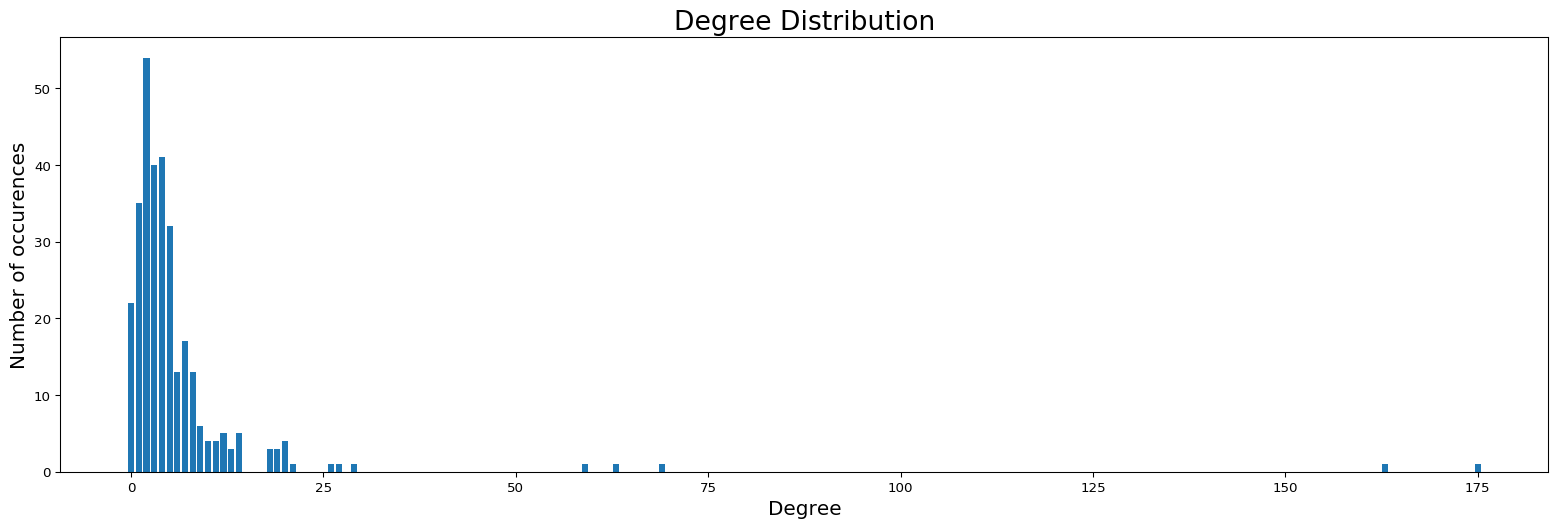

In [43]:
# Extracting degrees
degrees = []
in_degrees = []
out_degrees = []

N = 500

for i in validCharacterNames:
  degrees.append(G.degree()[i])
  in_degrees.append(G.in_degree()[i])
  out_degrees.append(G.out_degree()[i])


# degrees
max_deg = np.amax(degrees)
min_deg = np.amin(degrees)

v = range(min_deg, max_deg+2)

hist, bins = np.histogram(degrees, v)

bins = bins[:-1]

plt.figure(1, figsize=[20,6], dpi=96)
plt.bar(bins, hist)

plt.title("Degree Distribution", fontsize=20)
plt.ylabel("Number of occurences", fontsize=15)
plt.xlabel("Degree", fontsize=15)
plt.savefig(path_plots + "degree_distribution.png")
plt.show()
plt.close()

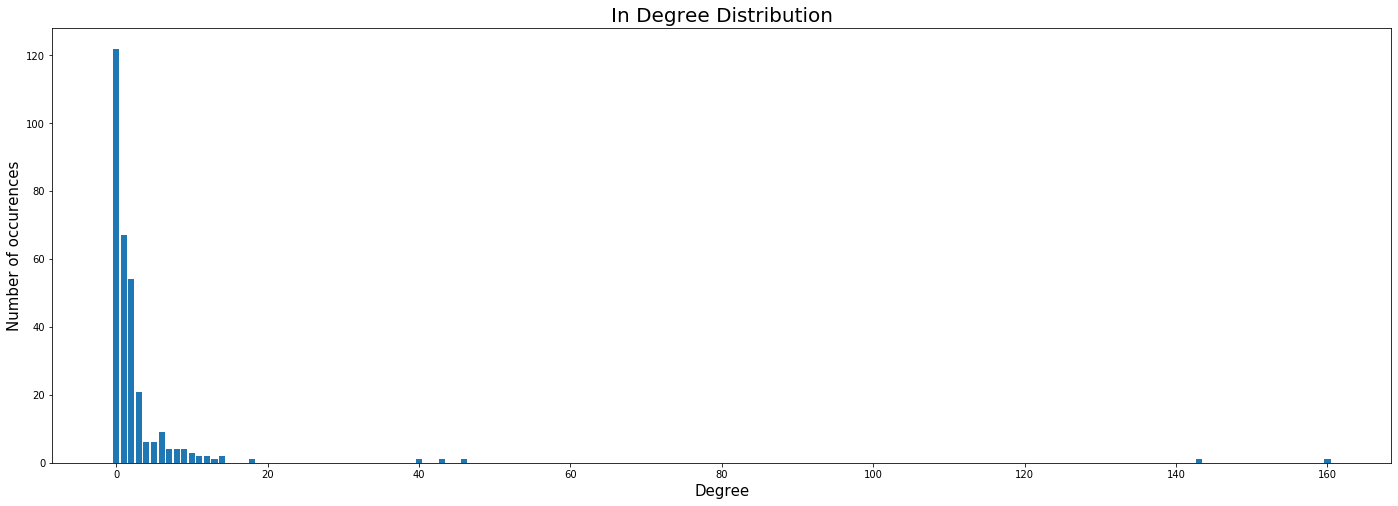

In [44]:
# in degrees
max_deg = np.amax(in_degrees)
min_deg = np.amin(in_degrees)

v = range(min_deg, max_deg+2)

hist, bins = np.histogram(in_degrees, v)

bins = bins[:-1]

plt.figure(1, figsize=[24,8])
plt.bar(bins, hist)

plt.title("In Degree Distribution", fontsize=20)
plt.ylabel("Number of occurences", fontsize=15)
plt.xlabel("Degree", fontsize=15)
plt.savefig(path_plots + "in_degree_distribution.png")
plt.show()
plt.close()

23 0


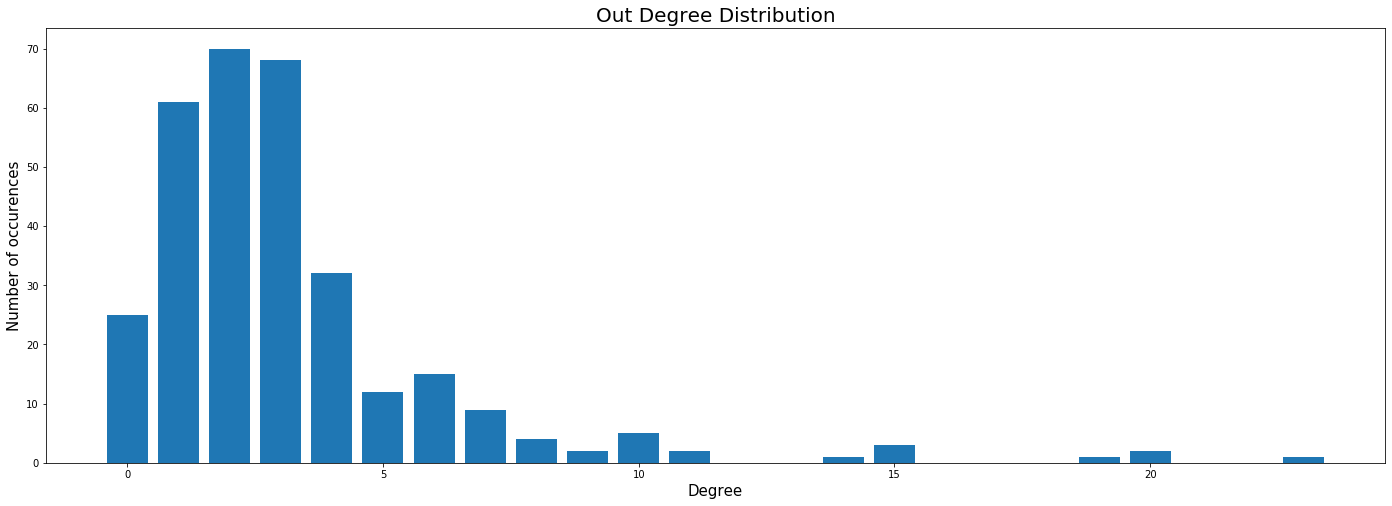

In [45]:
# out degrees
max_deg = np.amax(out_degrees)
min_deg = np.amin(out_degrees)

print(max_deg, min_deg)
v = range(min_deg, max_deg+2)

hist, bins = np.histogram(out_degrees, v)

bins = bins[:-1]

plt.figure(1, figsize=[24,8])
plt.bar(bins, hist)

plt.title("Out Degree Distribution", fontsize=20)
plt.ylabel("Number of occurences", fontsize=15)
plt.xlabel("Degree", fontsize=15)
plt.savefig(path_plots + "out_degree_distribution.png")
plt.show()
plt.close()

In [46]:
sorted([(y, x) for (x,y) in G.out_degree])

[(0, 'Ants in my Eyes Johnson'),
 (0, 'Attila Starwar'),
 (0, 'Father Bob'),
 (0, 'Fleeb'),
 (0, "Gar's Mytholog"),
 (0, 'Jon'),
 (0, 'Lisa'),
 (0, 'Little Dipper'),
 (0, 'Loggins'),
 (0, 'Lucy'),
 (0, 'Michael Denny and the Denny Singers'),
 (0, 'Michael Jenkins'),
 (0, 'Mr. Sneezy'),
 (0, 'Octopus Man'),
 (0, 'Real Fake Doors Salesman'),
 (0, 'Shlaammi'),
 (0, 'Shmlamantha Shmlicelli'),
 (0, 'Shmlangela Shmlobinson-Shmlower'),
 (0, 'Shmlona Shmlobinson'),
 (0, 'Shmlonathan Shmlower'),
 (0, 'Shmlony Shmlicelli'),
 (0, 'Tinkles'),
 (0, 'Tophat Jones'),
 (0, 'Vampire Master'),
 (0, "Zarbadar's Mytholog"),
 (1, 'Adjudicator Rick'),
 (1, 'Agency Director'),
 (1, 'Alexander'),
 (1, 'Amish Cyborg'),
 (1, 'Armagheadon'),
 (1, 'Artist Morty'),
 (1, 'Baby Legs'),
 (1, 'Bearded Lady'),
 (1, 'Benjamin'),
 (1, 'Canklanker Thom'),
 (1, 'Chris'),
 (1, 'Conroy'),
 (1, 'Crab Spider'),
 (1, 'Cult Leader Morty'),
 (1, 'Daron Jefferson'),
 (1, 'David Letterman'),
 (1, 'Dr. Glip-Glop'),
 (1, 'Dr. Schmidt

## Plotting Networks

### Character Network (Ricks & Mortys)

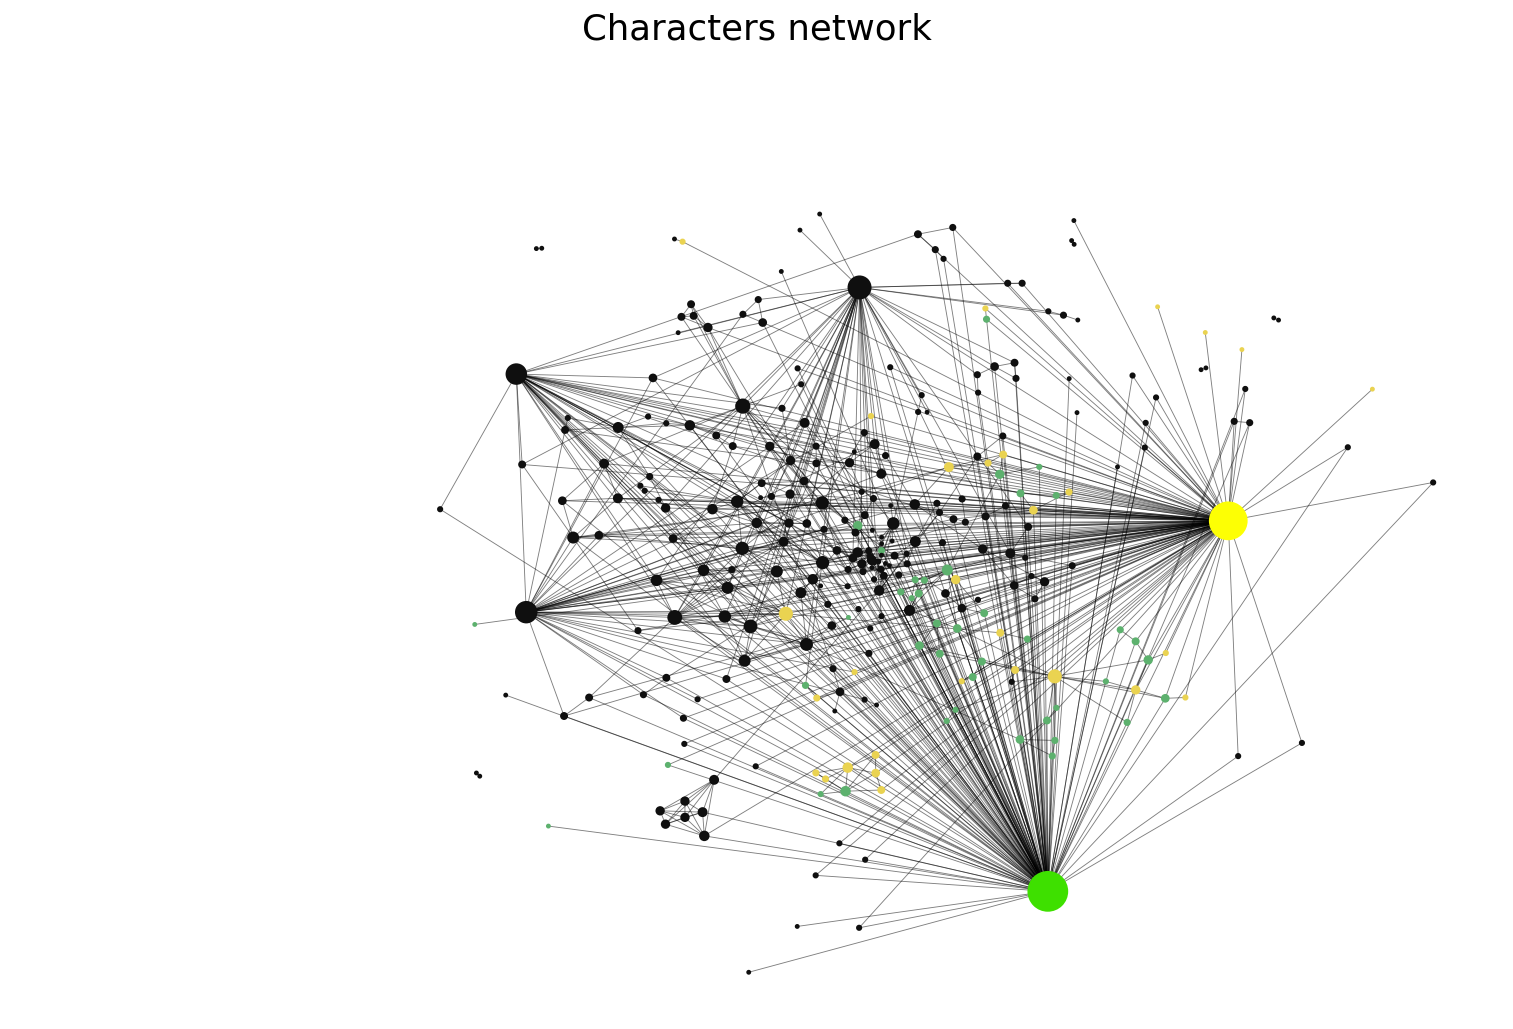

In [47]:
from fa2 import ForceAtlas2

# Setup forceatlas2
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=2,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=0.35,
                        strongGravityMode=False,
                        gravity=7,

                        # Log
                        verbose=False)

node_colors = []

# Color nodes based on party
for c in G.to_undirected():
    # specie = nx.get_node_attributes(G.to_undirected(), 'Specie').get(c)
    if "Rick" in c:
      color = "#5db16e";
    elif "Morty" in c:
      color = "#ead351"
    else:
      color = "#0f0f0f"

    if c == 'Rick Sanchez':
        color = '#3ee000'
    elif c == 'Morty Smith':
        color = '#fdff04'
    
    node_colors.append(color)

# Assign node sizes based on degree
node_sizes = [degree * 3 for (n, degree) in nx.degree(G.to_undirected())]

positions_undirected = forceatlas2.forceatlas2_networkx_layout(G.to_undirected(), pos=None, iterations=500)

plt.figure(figsize=(15,10),dpi=128)
plt.title('Characters network', fontsize = 20)
nx.draw_networkx_nodes(G.to_undirected(), positions_undirected, node_size=node_sizes, with_labels=False, node_color=node_colors)
nx.draw_networkx_edges(G.to_undirected(), positions_undirected, width=.5, alpha=.5)
plt.axis('off')
# plt.savefig("graph.png")
plt.show()

### Character Network (Ricks & Mortys w/ Images)

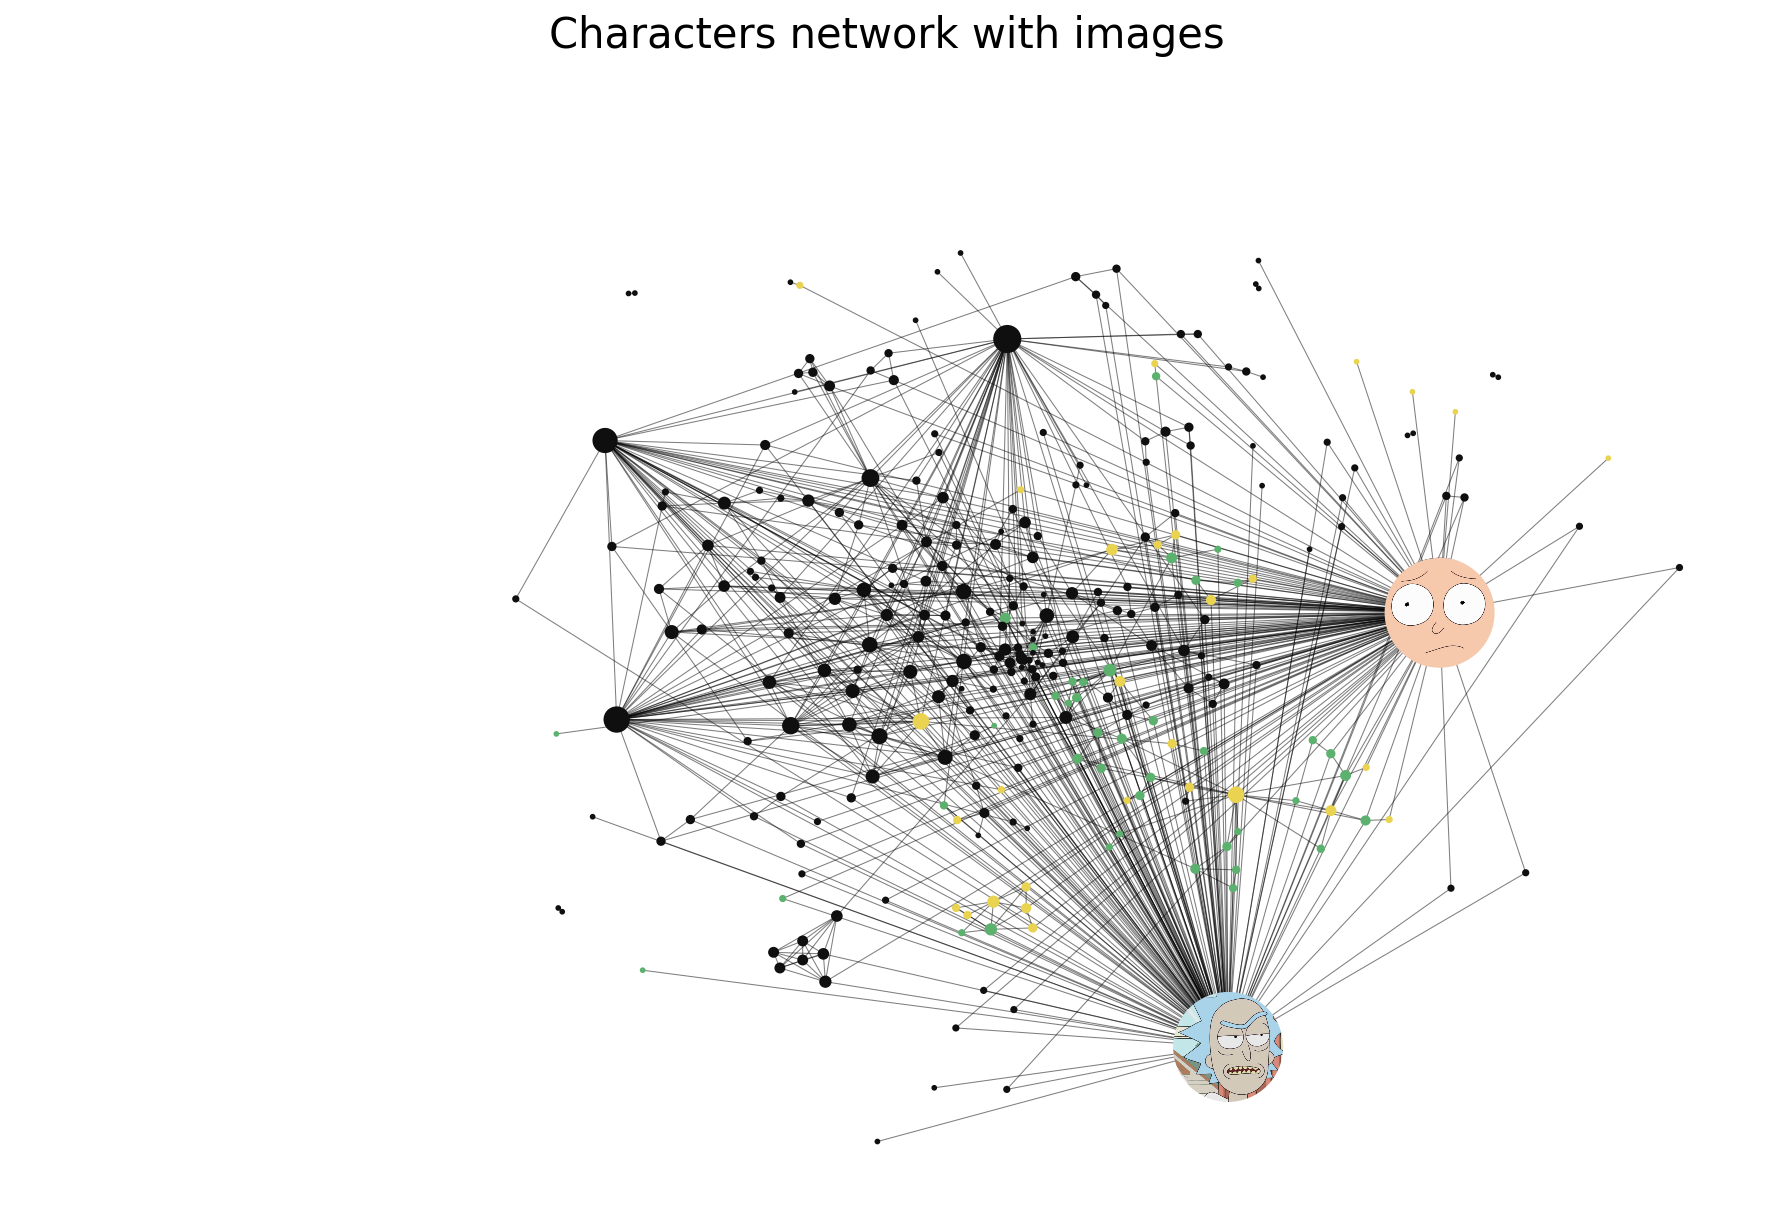

In [48]:
import matplotlib.patches as patches

plt.figure(figsize=(15,10),dpi=150)
plt.title('Characters network with images', fontsize = 20)
nx.draw_networkx_nodes(G.to_undirected(), positions_undirected, node_size=node_sizes, with_labels=False, node_color=node_colors)
nx.draw_networkx_edges(G.to_undirected(), positions_undirected, width=.5, alpha=.5)
plt.axis('off')

ax=plt.gca()
fig=plt.gcf()
trans = ax.transData.transform
trans2 = fig.transFigure.inverted().transform
imsize = 0.1 # this is the image size
for n in G.nodes():
  if n == 'Rick Sanchez' or n == 'Morty Smith':
    (x,y) = positions_undirected[n]
    xx,yy = trans((x,y)) # figure coordinates
    xa,ya = trans2((xx,yy)) # axes coordinates
    a = plt.axes([xa-imsize/2.0,ya-imsize/2.0, imsize, imsize ])
    im = a.imshow(nx.get_node_attributes(G, 'Image')[n], aspect='equal')
    # Round images
    patch = patches.Circle((150,150), 110, facecolor='none')
    a.add_patch(patch)
    im.set_clip_path(patch)
    a.axis('off')
# plt.savefig("graph-with-images.png")
plt.show()

### Character Network (Status)

(-151.2170366009246,
 110.82549703974698,
 -102.32388358242414,
 114.63727676677536)

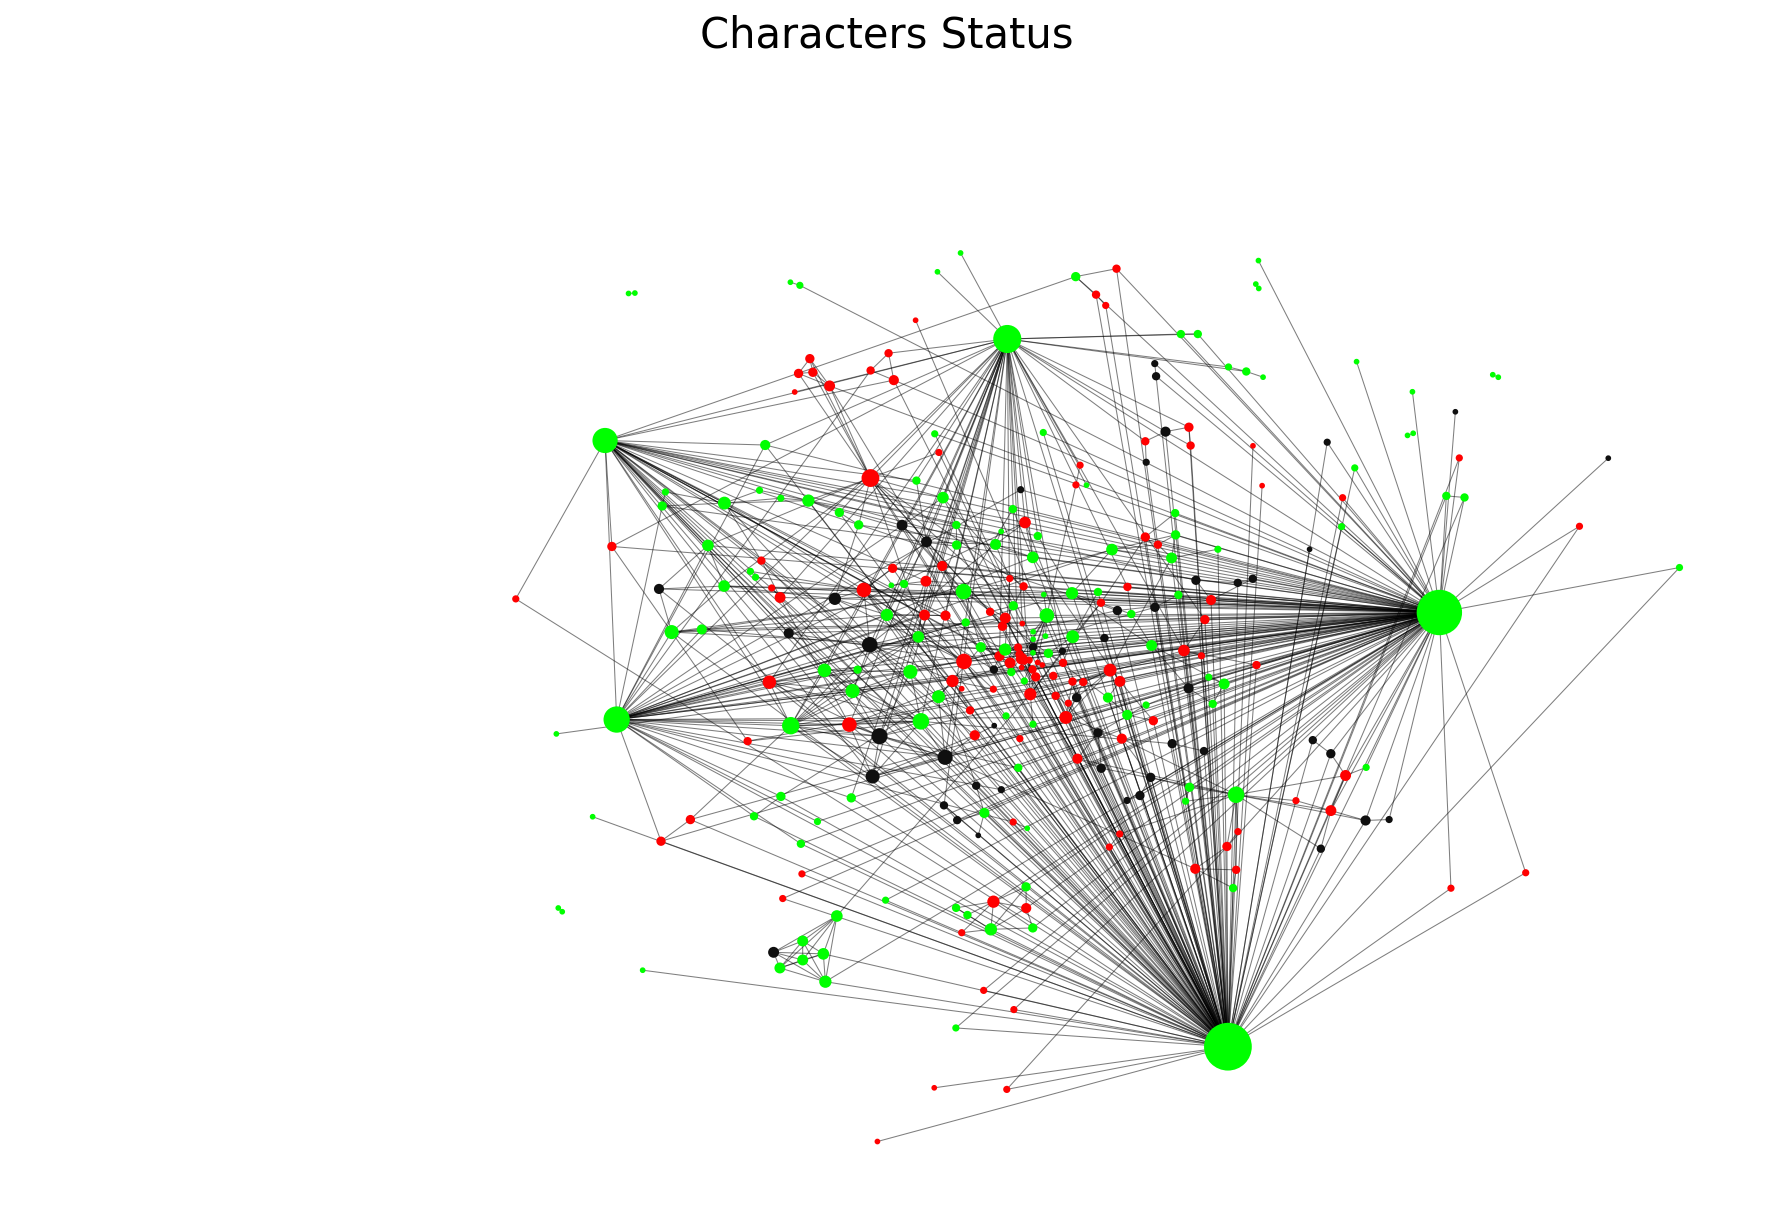

In [49]:
node_colors = []

# Color nodes based on status
for c in G.to_undirected():
    status = nx.get_node_attributes(G.to_undirected(), 'Status').get(c)
    if status == "Dead":
      color = "#FF0000";
    elif status == "Alive":
      color = "#00FF00"
    elif status == "unknown":
      color = "#0f0f0f"
    
    node_colors.append(color)

plt.figure(figsize=(15,10),dpi=150)
plt.title('Characters Status', fontsize = 20)
nx.draw_networkx_nodes(G.to_undirected(), positions_undirected, node_size=node_sizes, with_labels=False, node_color=node_colors)
nx.draw_networkx_edges(G.to_undirected(), positions_undirected, width=.5, alpha=.5)
plt.axis('off')

### Character Network (Specie)

(-151.2170366009246,
 110.82549703974698,
 -102.32388358242414,
 114.63727676677536)

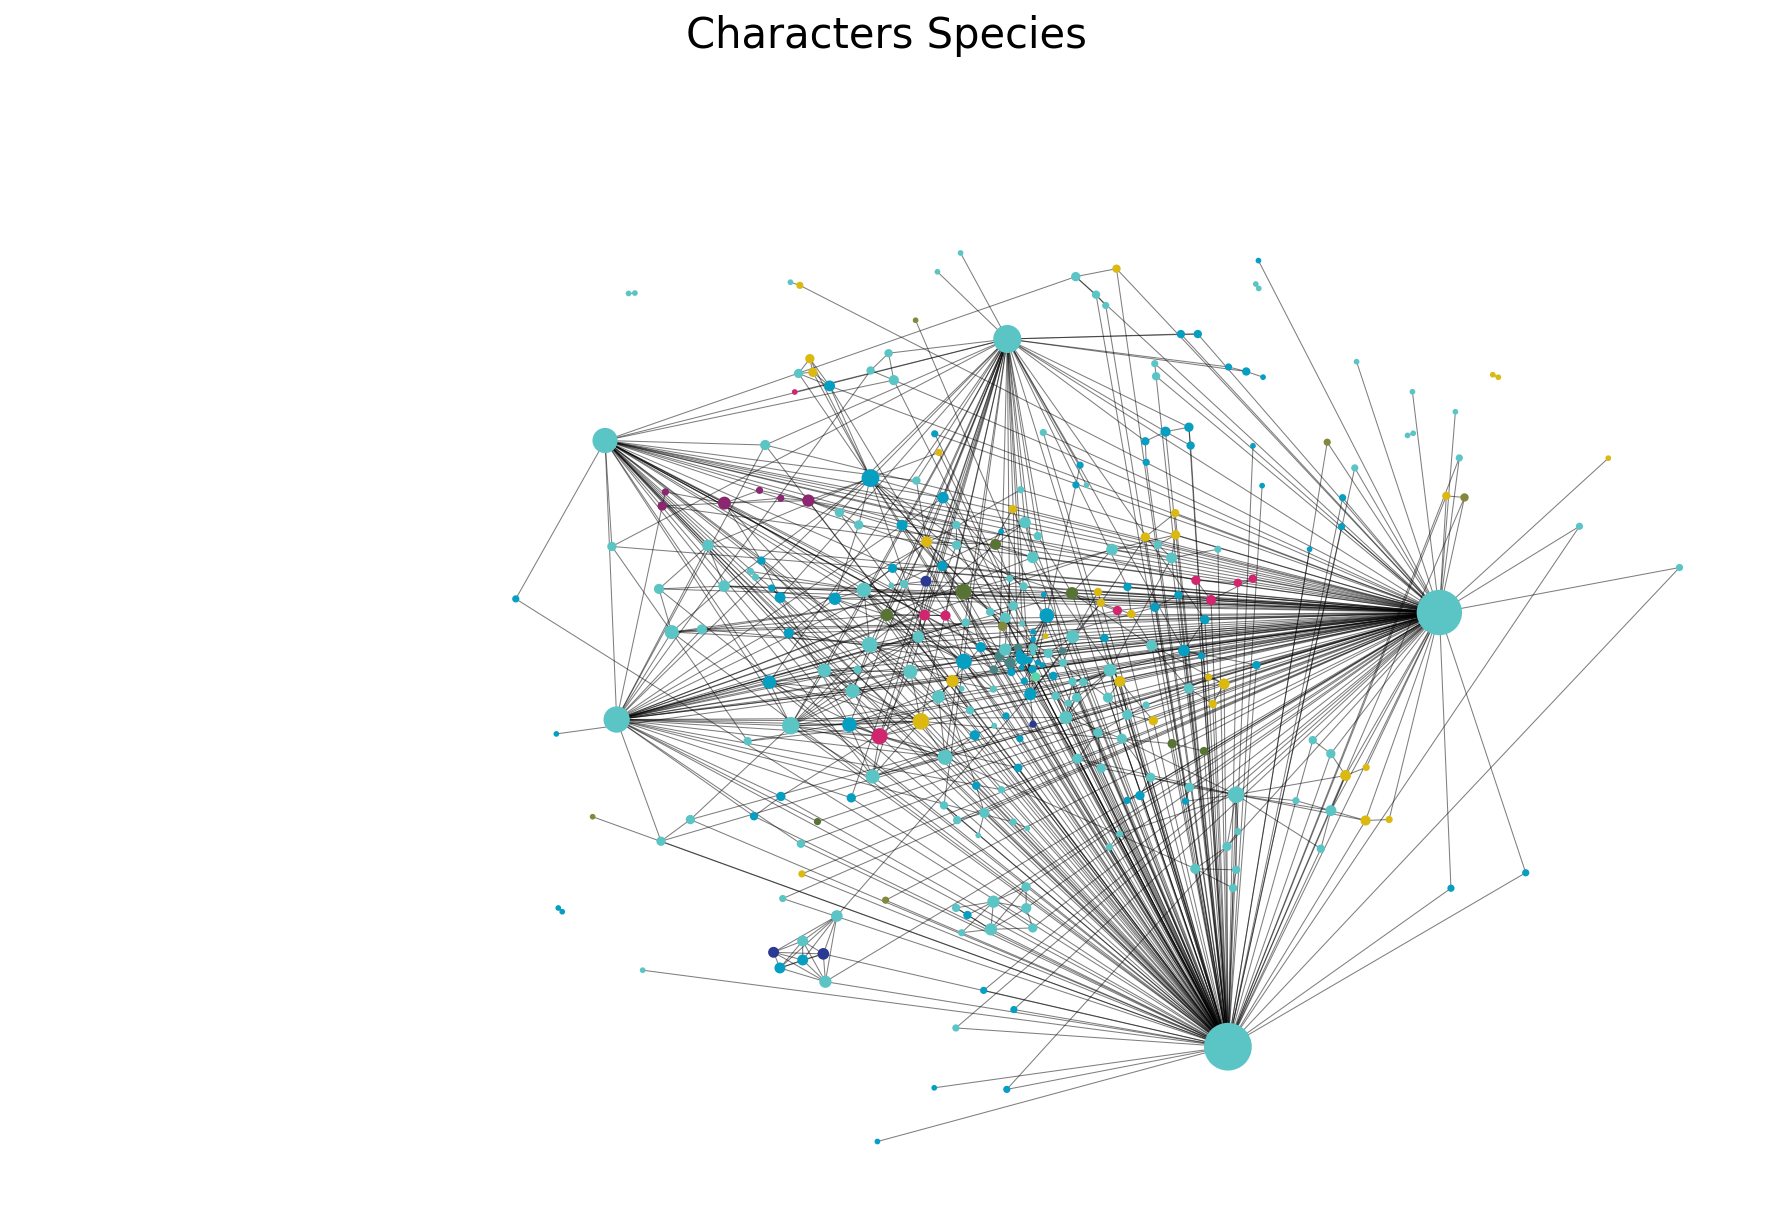

In [50]:
node_colors = []
species_colors = {}
# Color nodes based on specie
for c in G.to_undirected():
    specie = nx.get_node_attributes(G.to_undirected(), 'Specie').get(c)
    if specie in species_colors.keys():
      color = species_colors[specie]
    else:
      color = "#{:06x}".format(random.randint(0, 0xFFFFFF))
      species_colors[specie] = color

    node_colors.append(color)

plt.figure(figsize=(15,10),dpi=150)
plt.title('Characters Species', fontsize = 20)
nx.draw_networkx_nodes(G.to_undirected(), positions_undirected, node_size=node_sizes, with_labels=False, node_color=node_colors)
nx.draw_networkx_edges(G.to_undirected(), positions_undirected, width=.5, alpha=.5)
plt.axis('off')

# Rick and Morty Analysis

## Preparation of lists of tokens

In [0]:
#function returing the list of tokens for the season, half of season, and character given
#for now it catches only '''Morty:''' text ''' formatting and '''Morty'''

#ex season='01', char='Morty' half=1
def getwords(season,char,half):
  words=[]

  sw=set(stopwords.words('english'))
  tokens=[]
  for row in df_ep.iterrows():
    if str(row[1][1])[:3]=='S'+season:
      if (int(str(row[1][1])[5:6])<6 and half==1) or (int(str(row[1][1])[5:6])>=6 and half==2):
        verse=row[1][4]

        phrase="'''"+char+":'''.+?(?=''')"
        found1 = re.findall(phrase, verse, re.S)

        phrase="'''"+char+"'''.+?(?=\n''')"
        found2 = re.findall(phrase, verse, re.S)

        phrase="("+char+":).+?(?=\w+:)"
        found3 = re.findall(phrase, verse, re.S)
        
        for ii in range(0,len(found1)):
          found1[ii]=found1[ii][(7+len(char)):]

        for ii in range(0,len(found2)):
          found2[ii]=found2[ii][(6+len(char)):]

        for ii in range(0,len(found3)):
          found3[ii]=found3[ii][(1+len(char)):]


        found=found1+found2+found3
        print(found2)
        
        #tokenize
        for ff in found:
          tokens+=word_tokenize(ff)

        #to lower
        tokens=[tt.lower() for tt in tokens]

        #excluding stopwords
        tokens = [t for t in tokens if not t in sw]

        #excluding punctuation and numbers
        for ii in range(0,len(tokens)):
          tokens[ii]=''.join(e for e in tokens[ii] if e.isalpha())
        tokens = [t for t in tokens if t!='']

        #append
        words+=tokens
    

  return words



In [52]:
M1a=getwords('01', 'Morty',1)
M1b=getwords('01', 'Morty',2)
M2a=getwords('02', 'Morty',1)
M2b=getwords('02', 'Morty',2)
M3a=getwords('03', 'Morty',1)
M3b=getwords('03', 'Morty',2)
R1a=getwords('01', 'Rick',1)
R1b=getwords('01', 'Rick',2)
R2a=getwords('02', 'Rick',1)
R2b=getwords('02', 'Rick',2)
R3a=getwords('03', 'Rick',1)
R3b=getwords('03', 'Rick',2)


[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]


## Swearing analysis

In [53]:
M1a

[]

In [54]:
a=[M1a,M1b,M2a,M2b,M3a,M3b]
b=[R1a,R1b,R2a,R2b,R3a,R3b]

a1=[M1,M2,M3]
b1=[R1,R2,R3]

x=['1a','1b', '2a', '2b', '3a', '3b']
x1=['1','2','3']

yM=[predict_prob(ii).mean() for ii in a]
yR=[predict_prob(ii).mean() for ii in b]

yM1=[predict_prob(ii).mean() for ii in a1]
yR1=[predict_prob(ii).mean() for ii in b1]

plt.figure(figsize=(10,6))
plt.plot(x, yM, yR)
plt.title("Profanity score for Rick and Morty over time")
plt.ylabel("Profanity score")
plt.xlabel("Seasons")
plt.legend(["Morty", "Rick"])
plt.show()

plt.figure(figsize=(10,6))
plt.plot(x1, yM1, yR1)
plt.title("Profanity score for Rick and Morty over time")
plt.ylabel("Profanity score")
plt.xlabel("Seasons")
plt.legend(["Morty", "Rick"])
plt.show()


NameError: ignored

# Sentiment Analysis

## Extracting transcripts from files

In [55]:
for i in range(0,len(df_ep)):
  name = df_ep.iloc[i]['Name']
  code = df_ep.iloc[i]['Code']

  if("S01" in code):
    if("9" in name):
      name = name.replace("#9","9")
    if(":" in name):
      name = name.replace(":","-")

    path = "./Transcripts/Season 1/" +  name + ".json"
  elif ("S02" in code):
    if(":" in name):
      name = name.replace(":","-")
    path = "./Transcripts/Season 2/" + name + ".json"
  elif ("S03" in code):
    if(":" in name):
      name = name.replace(":","-")
    if ("The Ricklantis Mixup" in name):
      name = "Tales From the Citadel"
    path = "./Transcripts/Season 3/" + name + ".json"

  if os.path.isfile(path):
    # Get the text
    content = io.open(path, encoding='utf-8').read()
    df_ep.set_value(i,'Transcript', content)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


In [56]:
df_ep.head(10)

,Name,Code,Air Date,Views,Transcript
0,Pilot,S01E01,"December 2, 2013",0,[[File:S3e1_pilot_callback.png|thumb]]\n\n{{Tr...
1,Lawnmower Dog,S01E02,"December 9, 2013",0,{{Transcriptbox|p = Pilot|n = Anatomy Park (ep...
2,Anatomy Park,S01E03,"December 16, 2013",0,{{Transcriptbox|p = Lawnmower Dog|n = M. Night...
3,M. Night Shaym-Aliens!,S01E04,"January 13, 2014",0,{{Transcriptbox|p = Anatomy Park (episode)|n =...
4,Meeseeks and Destroy,S01E05,"January 20, 2014",0,{{Transcriptbox|p=M. Night Shaym-Aliens!|n=Ric...
5,Rick Potion #9,S01E06,"January 27, 2014",0,{{Transcriptbox|p=Meeseeks and Destroy|n=Raisi...
6,Raising Gazorpazorp,S01E07,"March 10, 2014",0,{{Transcriptbox|p=Rick Potion 9|n=Rixty Minute...
7,Rixty Minutes,S01E08,"March 17, 2014",0,{{Transcriptbox|p=Raising Gazorpazorp|n=Someth...
8,Something Ricked This Way Comes,S01E09,"March 24, 2014",0,{{Transcriptbox|p=Rixty Minutes|n=Close Rick-c...
9,Close Rick-counters of the Rick Kind,S01E10,"April 7, 2014",0,{{Transcriptbox|p=Something Ricked This Way Co...


In [0]:
banned_words = set(stopwords.words('english'))
banned_words.add('br')
banned_words.add('p')
banned_words.add('mr')

characters_names = list(df['Name'])
characters_names = [x.lower() for x in characters_names]

## Keywords

In [58]:
url = "https://ndownloader.figshare.com/files/360592"
s = requests.get(url).content
st = s.decode('utf-8')
# Cutting first two lines
sentiments = st.split("\n",2)[2];

df_sent = pd.read_csv(io.StringIO(sentiments), sep="\t",encoding = 'utf-8')
df_sent.head(5)

,word,happiness_rank,happiness_average,happiness_standard_deviation,twitter_rank,google_rank,nyt_rank,lyrics_rank
0,laughter,1,8.50,0.9313,3600,--,--,1728
1,happiness,2,8.44,0.9723,1853,2458,--,1230
2,love,3,8.42,1.1082,25,317,328,23
3,happy,4,8.30,0.9949,65,1372,1313,375
4,laughed,5,8.26,1.1572,3334,3542,--,2332


In [0]:
key_words = df_sent['word'].tolist()

## Sentiment function

In [0]:
def sentiment(tokens):
    # Adding happiness of every word
    sum = 0
    for token in tokens:
      # Checking if we can evaluate the sentiment of the word
        if(token in key_words):
            sum += df_sent.loc[df_sent['word'] == token].iloc[0].happiness_average
    # Returning the average
    return sum/len(tokens)

## Tokenizing & Sentiment Calculation

In [61]:
# Adding Column to df
df_ep['Sentiment Score'] = 0.00

# Seasons tokens
s1_tk = []
s2_tk = []
s3_tk = []

# For every episode
for i in range(0,len(df_ep)):
  name = df_ep.iloc[i]['Name']
  code = df_ep.iloc[i]['Code']
  transcript = df_ep.iloc[i]['Transcript']
    
  # Tokenizing, excluding stopwords, punctuation & numbers
  good_words = []
      
  # Tokenizing
  t = word_tokenize(transcript)
      
  # To lowercase
  t = [tt.lower() for tt in t]

  # Excluding punctuation and numbers
  for word in t:
    if word.isalpha() and word!='' and word not in banned_words:
      good_words.append(word)
          
  # Excluding twitter handles
  good_words = [t for t in good_words if not t in characters_names]

  sentiment_score = sentiment(good_words)

  if("S01" in code):
    s1_tk += good_words
  elif ("S02" in code):
    s2_tk += good_words
  elif ("S03" in code):
    s3_tk += good_words

  df_ep.set_value(i,'Sentiment Score', sentiment_score)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


## Plotting Sentiment

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  app.launch_new_instance()


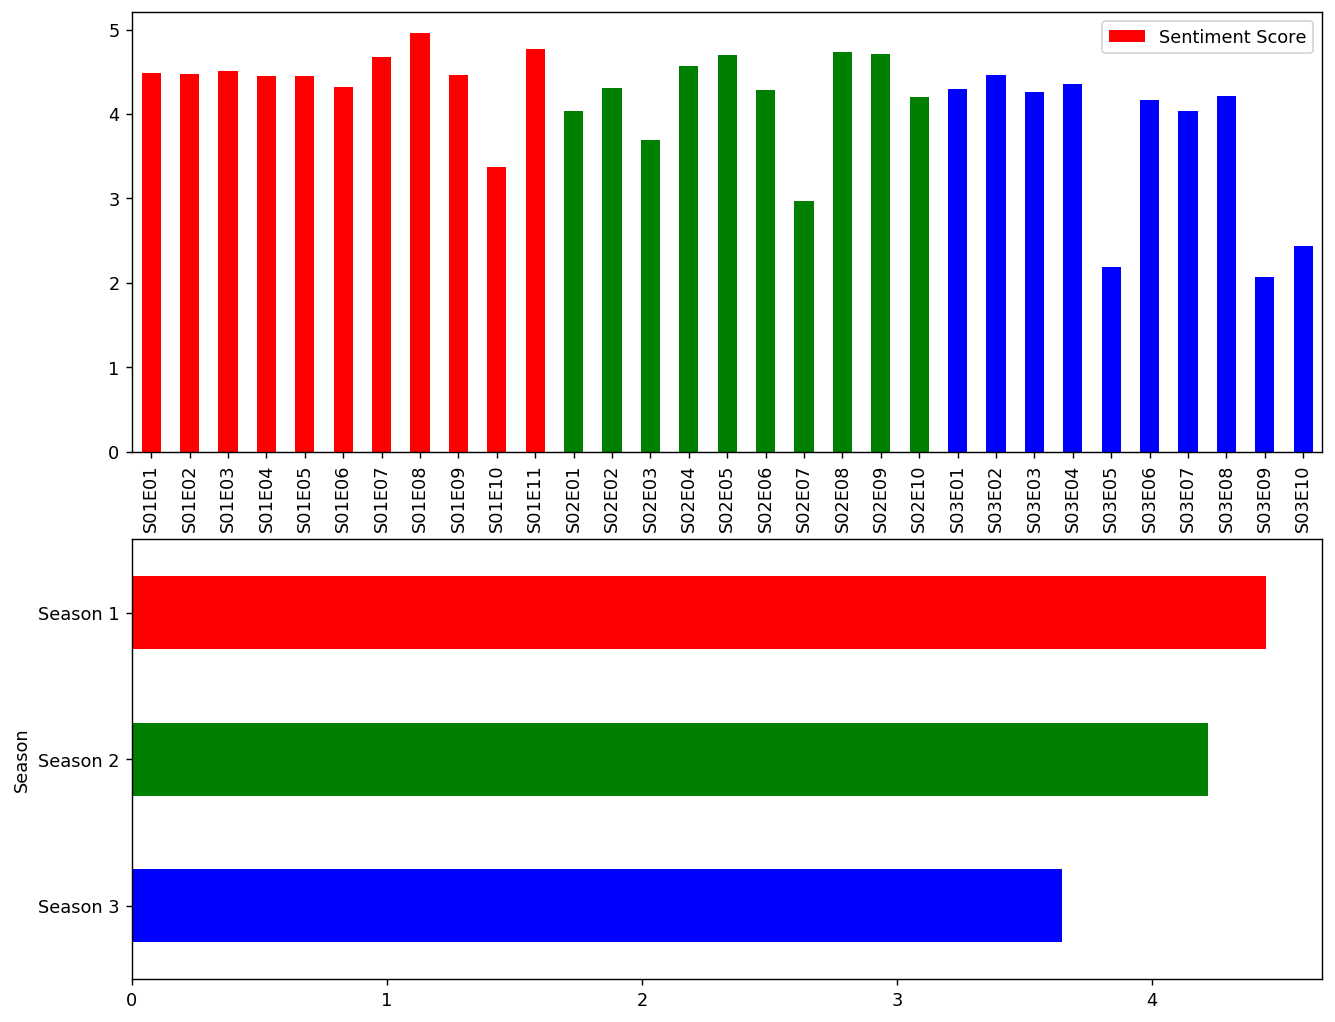

In [62]:
colors = []
df_ep['Season'] = "None"

# For every episode
for i in range(0,len(df_ep)):
  code = df_ep.iloc[i]['Code']

  if("S01" in code):
    colors.append('r')
    df_ep.set_value(i,'Season', 'Season 1')
  elif ("S02" in code):
    colors.append('g')
    df_ep.set_value(i,'Season', 'Season 2')
  elif ("S03" in code):
    colors.append('b')
    df_ep.set_value(i,'Season', 'Season 3')

fig = plt.figure(figsize=(12,10),dpi=128)

ax1 = fig.add_subplot(211)
df_ep.plot.bar(x='Code', y='Sentiment Score', rot=90, color=colors, ax=ax1)

colors = ['b','g','r']
ax2 = fig.add_subplot(212)
df_ep.groupby('Season')['Sentiment Score'].mean().sort_values().plot(kind='barh', ax=ax2, color = colors)

## Compute the TF-IDF

### Season 1

In [0]:
# TF Term Frequency 
s1_count = {}
for ii in s1_tk:
    if ii in s1_count:
        s1_count[ii] += 1
    else:
        s1_count[ii] = 1
  
# IDF Inverse Data Frequency
s1_idf = {}
for ii in s1_count:
    if ii in s2_tk and ii in s3_tk:
      n = 3
    elif ii in s2_tk or s3_tk :
      n = 2
    else:
      n = 1
    s1_idf[ii]=math.log(3/n)

# TF-IDF
s1_tfidf = {}
for ii in s1_count:
    s1_tfidf[ii] = s1_count[ii] * s1_idf[ii]

In [64]:
#10 most popular words in either of parties
print("Top 10 words of S1:")
c1 = Counter(s1_tfidf)
h1 = c1.most_common(10)
for ii in h1:
    print(ii[0])

Top 10 words of S1:
span
arial
baseline
ltr
meeseeks
italic
needful
snuffles
bloom
jacob


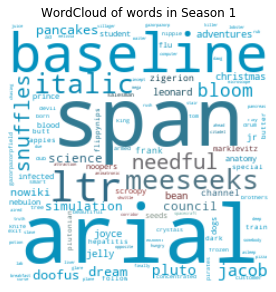

In [65]:
f = plt.figure(figsize=[16,8])

# Season 1
# Photo source: 
text_s1 = ""
for ii in s1_count:
    text_s1 += ((ii + ' ') * round(s1_tfidf[ii]))

# prepare the mask
response = requests.get('https://i.pinimg.com/236x/99/b2/73/99b273950aa91aaf1afd9f70e6c07099--rick-and-morty-tees.jpg')
mask = np.array(PIL.Image.open(BytesIO(response.content)))

# create the wordcloud
wc =  WordCloud(background_color="white", mode="RGBA", max_words=200, mask=mask, collocations=False).generate(text_s1)

image_colors = wordcloud.ImageColorGenerator(mask)

f.add_subplot(1, 3, 1)
plt.imshow(wc.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud of words in Season 1")

# Show both wordclouds
plt.show(block=True)